In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch

all_weight = torch.load("/content/eff_b4_0.pt")

In [ ]:
from torchvision import models
from torch import nn

model = models.efficientnet_b4()#.cuda()

for param in model.parameters():
    param.requires_grad = True

classifier = nn.Sequential(
    nn.Linear(in_features=model.classifier[1].in_features, out_features=250),
    nn.Linear(250, 100),
    nn.Linear(in_features=100, out_features=6)
)
model.classifier  = classifier

In [ ]:
from transformers import Mask2FormerForUniversalSegmentation
from torchvision import models
from torch import nn
model = models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = True

classifier = nn.Sequential(
    nn.Linear(in_features=model.fc.in_features, out_features=250),
    nn.Linear(250, 100),
    nn.Linear(in_features=100, out_features=6)
)
model.fc  = classifier
print(classifier)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 175MB/s]


Sequential(
  (0): Linear(in_features=2048, out_features=250, bias=True)
  (1): Linear(in_features=250, out_features=100, bias=True)
  (2): Linear(in_features=100, out_features=6, bias=True)
)


In [ ]:
from transformers import Mask2FormerForUniversalSegmentation
from torch import Tensor
import torch.nn as nn
device = torch.device("cuda")
class PolypSegmentationNetwork(nn.Module):
    def __init__(self):
        super(PolypSegmentationNetwork, self).__init__()

        # Tạo instance của Mask2FormerForSegmentation
        self.mask2former = Mask2FormerForUniversalSegmentation.from_pretrained(
            "facebook/mask2former-swin-base-coco-panoptic")


    def forward(self, pixel_values, class_labels=None, mask_labels=None):
        outputs = self.mask2former(
            pixel_values=pixel_values,
            class_labels=class_labels,
            mask_labels=mask_labels
        )

        # Tính toán đầu ra của lớp linear cuối cùng
        #logits = self.segmentation_head(outputs.last_hidden_state)
        return outputs
from transformers import Mask2FormerForUniversalSegmentation

seg_model = PolypSegmentationNetwork()
seg_model = seg_model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/9.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/432M [00:00<?, ?B/s]

In [ ]:
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.input_fc = nn.Linear(input_dim, 250)
        self.hidden_fc = nn.Linear(250, 100)
        self.output_fc = nn.Linear(100, output_dim)

    def forward(self, x):
        #x = [batch size, height, width]
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)

        #x = [batch size, height * width]
        h_1 = F.relu(self.input_fc(x))

        #h_1 = [batch size, 250]
        h_2 = F.relu(self.hidden_fc(h_1))

        #h_2 = [batch size, 100]
        y_pred = self.output_fc(h_2)
        #y_pred = [batch size, output dim]

        return y_pred
cls_model = MLP(input_dim=1024, output_dim=6)
# cls_model.load_state_dict(torch.load("/content/drive/MyDrive/Polyp_Segtimention/check_point/cls_60epoch/clf_model_fold0.pt"))
# cls_model.load_state_dict(torch.load("clf_model_0_932584.pt"))
cls_model = cls_model.to(device)

In [ ]:
predicted_values, target_values = predict(cls_model,test_loader, device)

report = classification_report(target_values, predicted_values, digits=6,target_names=le.classes_)
print(report)

In [ ]:
class MultiTaskNetwork(nn.Module):
    def __init__(self):
        super(MultiTaskNetwork, self).__init__()

        self.seg_loss=None
        self.clf_loss=None

        #Load mask2former model
        self.seg_model = seg_model

        #Load classification model
        self.clf_model = cls_model


    def forward(self, pixel_values, class_labels=None, mask_labels=None):
        seg_outputs = self.seg_model(
            pixel_values=pixel_values,
            class_labels=class_labels,
            mask_labels=mask_labels
        )

        #outputs = model(pixel_values=pixel_values.to(device))
        fmaps = seg_outputs.encoder_last_hidden_state
        avgPool = nn.AvgPool2d(kernel_size=(7,7))

        fmaps = avgPool(fmaps)
        fmaps = fmaps.reshape(fmaps.shape[0], fmaps.shape[1])
        clf_outputs = self.clf_model(fmaps)

        return (seg_outputs, clf_outputs)

    def predict(self, batch, preprocessor, device):
        seg_outputs = self.seg_model(pixel_values=batch["pixel_values"].to(device))
        #predict segmentation map
        original_images = batch["original_images"]
        target_sizes = [(image.shape[0], image.shape[1]) for image in original_images]
        predicted_segmentation_maps = preprocessor.post_process_semantic_segmentation(
            seg_outputs, target_sizes=target_sizes)

        #get encoder
        fmaps = seg_outputs.encoder_last_hidden_state
        avgPool = nn.AvgPool2d(kernel_size=(7,7))

        #predict class of images
        fmaps = avgPool(fmaps)
        fmaps = fmaps.reshape(fmaps.shape[0], fmaps.shape[1])
        predicted_labels = self.clf_model(fmaps)

        return predicted_segmentation_maps, predicted_labels


In [ ]:
# model = MultiTaskNetwork()
model.load_state_dict(all_weight)
device = torch.device("cuda")

model = model.to(device)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import cv2
import os
import  torchvision.transforms as transforms
#define transforms to preprocess input image into format expected by model
normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                    std=[0.5, 0.5, 0.5])
#inverse transform to get normalize image back to original form for visualization
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

#transforms to resize image to the size expected by pretrained model,
#convert PIL image to tensor, and
#normalize the image
import albumentations as A

ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255
normalize = transforms.Normalize(mean=ADE_MEAN,
                                    std=ADE_STD)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

transform2 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),

])
test_transform = A.Compose([
    A.Resize(width=224, height=224),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),

])
llabels = np.array(['adenocarcinoma', 'high-grade in', 'low-grade in', 'normal',
       'polyp', 'serrated adenoma'])
def saliency(img, model,label_idx,path):
    #we don't need gradients w.r.t. weights for a trained model
    for param in model.parameters():
        param.requires_grad = False

    #set model in eval mode
    model.eval()
    #transoform input PIL image to torch.Tensor and normalize
    input = transform(img)
    input = input.to(device)
    input.unsqueeze_(0)

    input2 = transform2(img).to(device)
    input2.unsqueeze_(0)

    #we want to calculate gradient of higest score w.r.t. input
    #so set requires_grad to True for input
    input.requires_grad = True
    #forward pass to calculate predictions
    preds = model(input)
    print(preds.shape)
    score, indices = torch.max(preds,axis=1)
    #backward pass to get gradients of score predicted class w.r.t. input image
    score.backward()
    #get max along channel axis
    slc, _ = torch.max(torch.abs(input.grad[0]), dim=0)
    #normalize to [0..1]
    slc = (slc - slc.min())/(slc.max()-slc.min())
    slc_map =  np.asarray(slc.cpu().numpy()*255, np.uint8)

    print(slc.shape)
    print("Prediction: ",llabels[indices])
    input_img = input2[0]
    heatmap = cv2.applyColorMap(slc_map, cv2.COLORMAP_JET)
    origin_img = np.transpose(input_img.cpu().detach().numpy(), (1, 2, 0))
    origin_img = np.asarray(origin_img, np.float64)
    heatmap = np.asarray(heatmap, np.float64)

    weight = cv2.addWeighted(origin_img,0.5, heatmap ,0.5,0)
    save_weight = np.clip(weight,0,1)
    plt.imsave("eff_100ep_"+os.path.basename(path),save_weight,cmap=plt.cm.jet)
    #apply inverse transform on image
    # with torch.no_grad():
    #     input_img = inv_normalize(input[0])
    #plot image and its saleincy map
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(input_img.cpu().detach().numpy(), (1, 2, 0)))
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1, 2, 2)
    plt.imshow(weight, cmap=plt.cm.jet)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [ ]:
model = model.to(device)

torch.Size([1, 6])
torch.Size([224, 224])
Prediction:  serrated adenoma


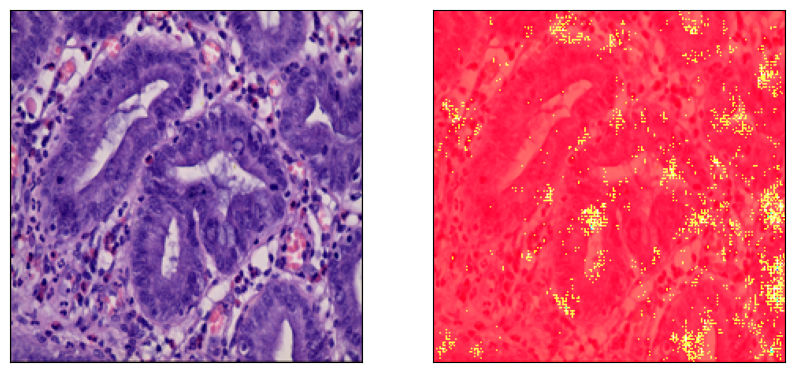

In [ ]:
import os
rd_im = "/content/drive/MyDrive/Polyp_Segtimention/EBHI-SEG/Serrated adenoma/image/GTDC2102188-3-400-002.png"
from PIL import Image
img = Image.open(rd_im).convert('RGB')
img.save("gt_"+os.path.basename(rd_im))
saliency(img, model,42,rd_im)

In [ ]:
 test = pd.read_csv("/kaggle/input/ebhi-csv/all/test_fold_0.csv")
test_data =  test[test.label=="normal"]
test_img = test_data.img_path.to_list()
lbls = test_data.label.to_list()


In [ ]:
folder = "/kaggle/input/ebhi-seg/"
import os
for i,img in enumerate(test_img):
    path = os.path.join(folder,img)
    print(path)
    print(lbls[i])
    from PIL import Image
    img = Image.open(path).convert('RGB')
    a = saliency(img, model,lbls[i])
    print(a)

In [ ]:
folders2 ="/kaggle/input/ebhi-seg/EBHI-SEG/Normal/image"
from PIL import Image
for imge in os.listdir(folders2):
    rd_im = os.path.join(folders2,imge)
    print(rd_im)
    img = Image.open(rd_im).convert('RGB')
    saliency(img, model,5)

In [ ]:
folders ="/kaggle/input/ebhi-seg/EBHI-SEG/Adenocarcinoma/image"
from PIL import Image
for imge in os.listdir(folders):
    rd_im = os.path.join(folder,imge)
    print(rd_im)
    img = Image.open(rd_im).convert('RGB')
    saliency(img, model,5)

In [ ]:
folders ="/kaggle/input/ebhi-seg/EBHI-SEG/High-grade IN/image"
from PIL import Image
for imge in os.listdir(folders):
    rd_im = os.path.join(folders,imge)
    print(rd_im)
    img = Image.open(rd_im).convert('RGB')
    saliency(img, model,5)

In [ ]:
data = np.load("/kaggle/input/best-weight/features.npz")

FileNotFoundError: ignored

In [ ]:
data['features'].shape

In [ ]:
data['img_labels'].shape

In [ ]:
ft_map =np.reshape(data['features'],(-1,7))

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
img_labels = le.fit_transform(data['img_labels'])

In [ ]:
import numpy as np
from PIL import Image
from torch.utils.data import Dataset

class ImageSegmentationDataset(Dataset):
  """Image segmentation dataset."""

  def __init__(self, dataset, data_path, transform):
    """
    Args:
        dataset
    """
    self.dataset = dataset
    self.data_path = data_path
    self.transform = transform

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    img_path = os.path.join(self.data_path, self.dataset.iloc[idx, 0])
    label_path = os.path.join(self.data_path, self.dataset.iloc[idx, 1])
    image_label = self.dataset.iloc[idx, 2]

    original_image = Image.open(img_path).convert('RGB')
    original_segmentation_map = Image.open(label_path)

    original_image = np.array(original_image)
    original_segmentation_map = np.array(original_segmentation_map.convert('1'))*1

    transformed = self.transform(image=original_image, mask=original_segmentation_map)
    image, segmentation_map = transformed['image'], transformed['mask']

    # convert to C, H, W
    image = image.transpose(2, 0, 1)

    return image, segmentation_map, original_image, original_segmentation_map, image_label